# Rice Image Classification

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

In [3]:
import splitfolders
splitfolders.ratio('Rice_Image_Dataset', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 5000 files [01:51, 44.78 files/s] 


In [4]:
BATCH = 64
IMG_WIDTH = 96
IMG_HEIGHT = 96

In [5]:
train_loader = tf.keras.preprocessing.image_dataset_from_directory( "./output/train",
                                                                   seed=123,
                                                                   image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                   batch_size=BATCH )

test_loader = tf.keras.preprocessing.image_dataset_from_directory( "./output/test",
                                                                  seed=123,
                                                                  image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                  batch_size=BATCH )

validation_loader = tf.keras.preprocessing.image_dataset_from_directory( "./output/val",
                                                                        seed=123,
                                                                        image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                        batch_size=BATCH )

Found 60846 files belonging to 5 classes.
Found 7935 files belonging to 5 classes.
Found 7965 files belonging to 5 classes.


In [6]:
class_names = train_loader.class_names
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


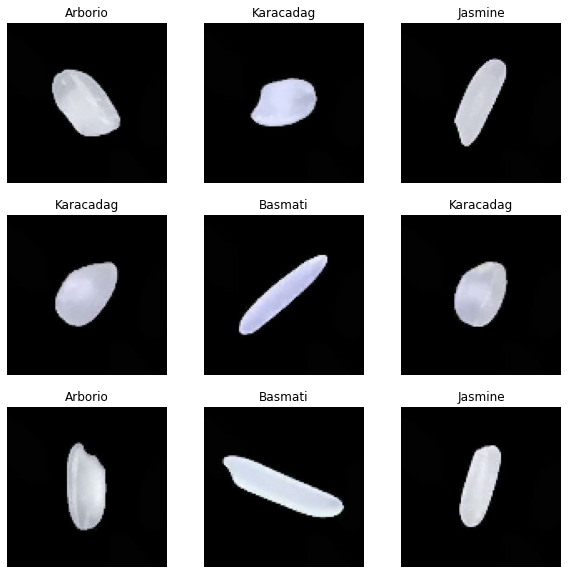

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_loader.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_loader.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = validation_loader.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#Model

In [10]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [11]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
  
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)       

In [14]:
#fitting

In [ ]:
epochs = 100
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/100


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        plt.ylabel("Predicted: "+class_names[np.argmax(score)])
        plt.title("Actual: "+class_names[labels[i]])
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])